In [ ]:
#Load the CSV files for the 4 years of data into PySpark DataFrame objects.
%pip install pyspark
#import findspark
#findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("data_cleaning").getOrCreate()

# Load the CSV files for each year
df_2005 = spark.read.csv(r"C:\Users\yashw\OneDrive\Desktop\603 project\2005.csv", header=True, inferSchema=True)
df_2006 = spark.read.csv(r"C:\Users\yashw\OneDrive\Desktop\603 project\2006.csv", header=True, inferSchema=True)
df_2007 = spark.read.csv(r"C:\Users\yashw\OneDrive\Desktop\603 project\2007.csv", header=True, inferSchema=True)
df_2008 = spark.read.csv(r"C:\Users\yashw\OneDrive\Desktop\603 project\2008.csv", header=True, inferSchema=True)


#Data is loaded by creating spark session 

combining all years data in to one 

In [7]:
df_all_years = df_2005.union(df_2006).union(df_2007).union(df_2008).union(df_2005)#.union(df_2002).union(df_2003).union(df_2004).union(df_2000).union(df_1999)

carrying out EDA and data preprocessing for ML model:

Checking for missing values and filling that with 0

In [8]:
# Check for missing values
for col in df_all_years.columns:
    num_missing = df_all_years.filter(df_all_years[col].isNull()).count()
    print("{}: {} missing values".format(col, num_missing))

# Fill missing values with 0
df_all_years = df_all_years.fillna(0)

Year: 0 missing values
Month: 0 missing values
DayofMonth: 0 missing values
DayOfWeek: 0 missing values
DepTime: 0 missing values
CRSDepTime: 0 missing values
ArrTime: 0 missing values
CRSArrTime: 0 missing values
UniqueCarrier: 0 missing values
FlightNum: 0 missing values
TailNum: 42474 missing values
ActualElapsedTime: 0 missing values
CRSElapsedTime: 0 missing values
AirTime: 0 missing values
ArrDelay: 0 missing values
DepDelay: 0 missing values
Origin: 0 missing values
Dest: 0 missing values
Distance: 0 missing values
TaxiIn: 0 missing values
TaxiOut: 0 missing values
Cancelled: 0 missing values
CancellationCode: 30650959 missing values
Diverted: 0 missing values
CarrierDelay: 0 missing values
WeatherDelay: 0 missing values
NASDelay: 0 missing values
SecurityDelay: 0 missing values
LateAircraftDelay: 0 missing values


There may be few duplicate rows so we need to drop the duplicates

In [9]:
df_all_years = df_all_years.dropDuplicates()

Here total delay is calculated and adding that column and adding that column to dataframe and also calculating monthly average delay. Here total delay column is used for ML model building.

In [10]:
# Add a new column that calculates the total delay
df_all_years = df_all_years.withColumn("total_delay", df_all_years.DepDelay + df_all_years.ArrDelay)

# Aggregate the data by month and calculate the average total delay
df_monthly_avg_delay = df_all_years.groupBy("Month").agg({"total_delay": "avg"})




Dropping unwanted  columns

In [11]:
df_all_years = df_all_years.drop("Cancelled", "CancellationCode", "Diverted")


Converting the Columns in to correct and required data types.

In [12]:
# Convert columns to the correct data type
df_all_years = df_all_years.withColumn("FlightNum", df_all_years["FlightNum"].cast("int"))
df_all_years = df_all_years.withColumn("CRSDepTime", df_all_years["CRSDepTime"].cast("int"))
df_all_years = df_all_years.withColumn("CRSArrTime", df_all_years["CRSArrTime"].cast("int"))


Creating a new column wheather the flight is delayed or not

In [13]:
# Create a new column that indicates whether a flight was delayed or not
df_all_years = df_all_years.withColumn("IsDelayed", (df_all_years["ArrDelay"] > 0).cast("int"))


Inappropriate and extreme values are replaced by the reasonable values

In [14]:
# Replace extreme values with a more reasonable value
from pyspark.sql.functions import when

df_all_years = df_all_years.withColumn("Distance", when(df_all_years["Distance"] > 10000, 10000).otherwise(df_all_years["Distance"]))

Splitting the Airline column into 2 saperate columns for airline and name of the carrier

In [15]:
# Split the Airline column into two separate columns for airline code and name
from pyspark.sql.functions import split

df_all_years = df_all_years.withColumn("AirlineCode", split(df_all_years["UniqueCarrier"], "").getItem(0))
df_all_years = df_all_years.withColumn("AirlineName", split(df_all_years["UniqueCarrier"], "").getItem(1))


In [17]:
# Save as CSV file locally
df_all_years.write.format("csv").option("header", "true").mode("overwrite").save("C:/Users/yashw/OneDrive/Desktop/603 project")

Counting the number of flights per year

In [18]:
df_all_years.groupBy('year').count().show()


+----+-------+
|year|  count|
+----+-------+
|2007|7453188|
|2006|7141915|
|2005|7140585|
|2008|2389213|
+----+-------+



In [27]:
from pyspark.sql.functions import count
years = df_all_years.groupBy('Year').agg(count('*').alias('count'))


In [22]:
year_counts = df_all_years.groupBy('Year').agg(count('*').alias('num_flights'))

Plotting the Number of flights by each carrier in a year

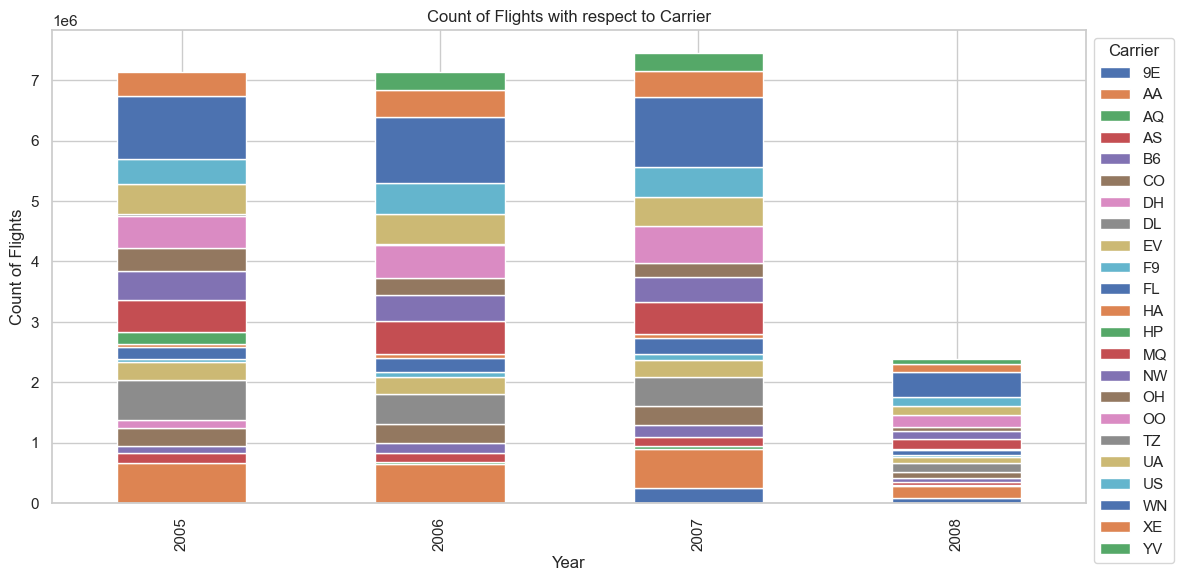

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the airline data by year and carrier, and count the number of flights
grouped_df =df_all_years.groupBy('Year', 'UniqueCarrier').count()

# Convert the grouped_df DataFrame to a Pandas DataFrame for plotting
grouped_df_pd = grouped_df.toPandas()

# Pivot the DataFrame to have carriers as columns and years as rows
pivot_df = grouped_df_pd.pivot(index='Year', columns='UniqueCarrier', values='count')

# Plot the graph
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel("Year")
plt.ylabel("Count of Flights")
plt.title("Count of Flights with respect to Carrier")
plt.legend(title='Carrier', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


Showing the top 10 highest average delay airports in the following years

In [29]:

from pyspark.sql.functions import avg, desc, row_number
from pyspark.sql.window import Window

# Compute average departure delay for each origin and year
delays = df_all_years.groupBy("Year", "Origin").agg(avg("DepDelay").alias("avg_delay"))

# Define window specification to rank origins by average delay within each year
window_spec = Window.partitionBy("Year").orderBy(desc("avg_delay"))

# Rank origins within each year based on average delay
ranked_delays = delays.withColumn("rank", row_number().over(window_spec))

# Filter top 10 origins for each year
top_origins = ranked_delays.filter("rank <= 10")

# Show the top 10 origin airports with highest average delay year-wise
top_origins.orderBy("Year", "rank").show()


+----+------+------------------+----+
|Year|Origin|         avg_delay|rank|
+----+------+------------------+----+
|2005|   CKB|             130.0|   1|
|2005|   OGD|             108.0|   2|
|2005|   CYS|             105.0|   3|
|2005|   BRW|22.153609831029186|   4|
|2005|   ACK| 22.07920792079208|   5|
|2005|   DLG|21.349557522123895|   6|
|2005|   EYW| 18.58011049723757|   7|
|2005|   OME|18.530259365994237|   8|
|2005|   ADK|18.489583333333332|   9|
|2005|   AKN|18.246648793565683|  10|
|2006|   ADK|              39.0|   1|
|2006|   ACK| 33.51196172248804|   2|
|2006|   CKB|              20.0|   3|
|2006|   FAY|19.151116951379763|   4|
|2006|   CWA|18.399141630901287|   5|
|2006|   PFN| 18.37011952191235|   6|
|2006|   ORD| 17.71121691919262|   7|
|2006|   AKN| 17.44345238095238|   8|
|2006|   EYW|17.311291963377418|   9|
|2006|   LWB| 17.17098445595855|  10|
+----+------+------------------+----+
only showing top 20 rows



Graph of top 15 highest flight counts in each year

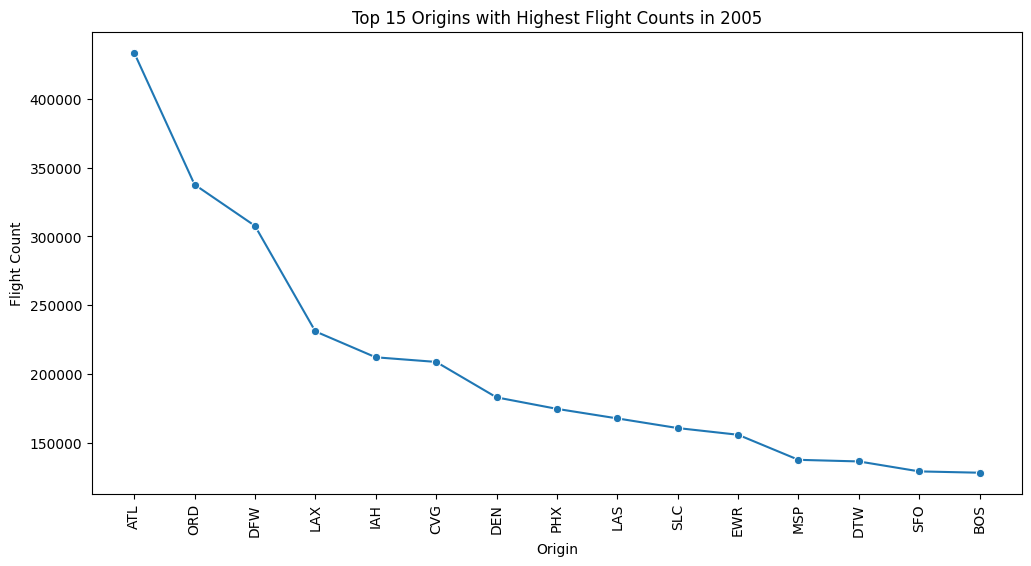

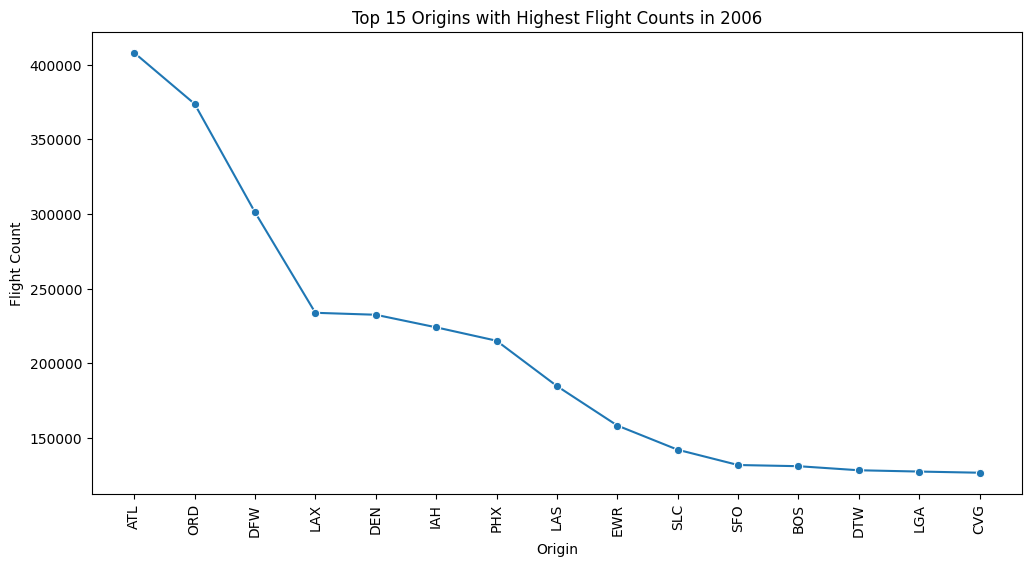

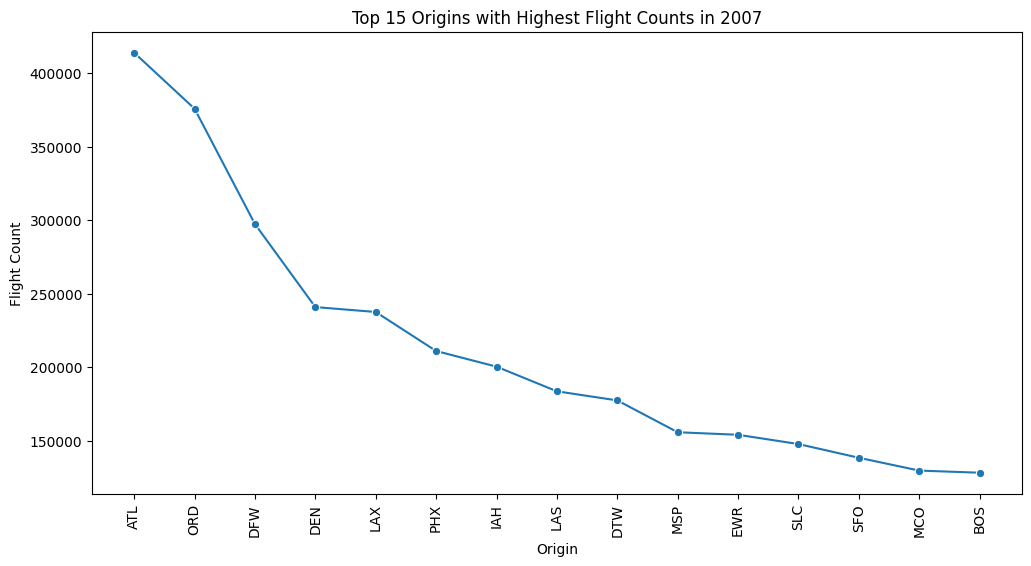

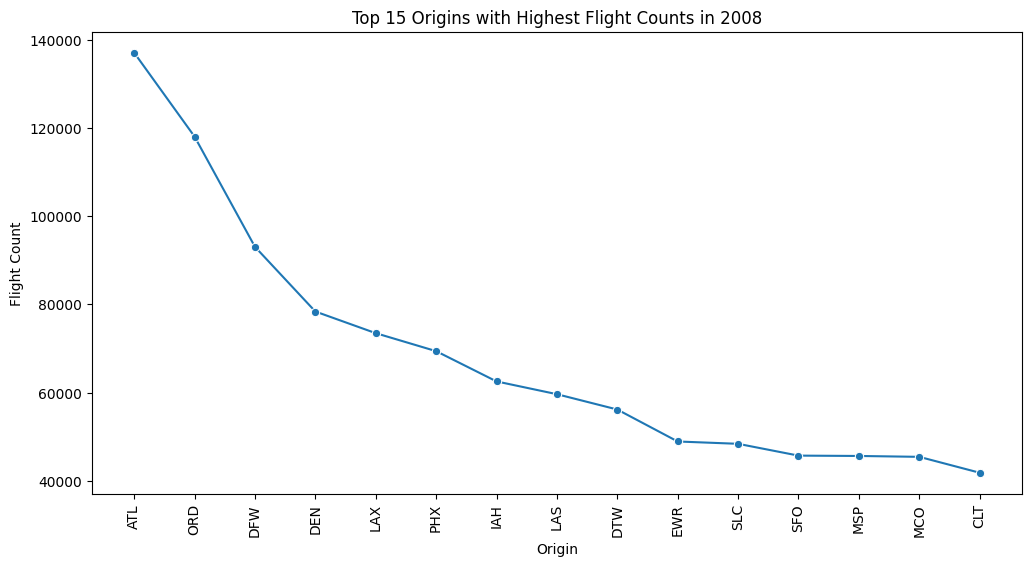

In [39]:
import matplotlib.pyplot as plt
top_origins_pd = top_origins.toPandas()

import seaborn as sns

years = top_origins_pd["year"].unique()
for year in years:
    year_data = top_origins_pd[top_origins_pd["year"] == year]
    origins = year_data["origin"]
    flight_counts = year_data["count"]

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=origins, y=flight_counts, marker="o")
    plt.xlabel("ORIGIN")
    plt.ylabel("FLIGHT COUNT")
    plt.title(f"Top 15 Origins with Highest Flight Counts in {year}")
    plt.xticks(rotation=90)
    plt.show()


Highest arrival flights in the following years are :

In [41]:
from pyspark.sql.functions import count, desc, max

max_arrival_flights = df_all_years.groupBy("DEST").agg(count("*").alias("arrival_count")) \
                                         .agg(max("DEST").alias("airport_with_max_count")) \
                                         .first()["airport_with_max_count"]


In [42]:
max_arrival_flights

'YUM'

Highest departure flights in the following years are :

In [45]:
from pyspark.sql.functions import desc, col

# Group the data by airport and count the number of departure flights
departure_counts = df_all_years.groupBy("ORIGIN").agg(count("*").alias("departure_count"))

# Find the airport with the highest number of departure flights
max_departure_flights = departure_counts.select("ORIGIN").orderBy(desc("departure_count")).first()["ORIGIN"]

In [46]:
max_departure_flights

'ATL'

The Busiest airport of all time is:

In [48]:
from pyspark.sql.functions import desc, col

# Group the data by airport and count the total number of flights
flight_counts = df_all_years.groupBy("ORIGIN").agg(count("*").alias("total_count"))

# Add the counts for the destination airports
flight_counts = flight_counts.union(
    df_all_years.groupBy("DEST").agg(count("*").alias("total_count"))
)

# Sum the counts for each airport and select the busiest one
busiest_airport = flight_counts.groupBy("ORIGIN").agg({"total_count": "sum"}) \
    .orderBy(desc("sum(total_count)")).first()["ORIGIN"]


In [49]:
busiest_airport

'ATL'

Highest delayed departures are from the following airports:

In [52]:
from pyspark.sql.functions import avg, desc

# Filter out cancelled flights
airline_df = df_all_years.filter(df_all_years["Cancelled"] == 0)

# Calculate delay in minutes for delayed flights
airline_df = airline_df.withColumn("DepDelayMinutes", airline_df["DepDelay"] * 1.0)

# Group by origin and calculate average departure delay
avg_delayed_departures = airline_df.groupBy("ORIGIN") \
                                   .agg(avg("DepDelayMinutes").alias("avg_delay")) \
                                   .orderBy(desc("avg_delay"))

# Filter for only airports with average delay greater than 0 minutes
delayed_departures = avg_delayed_departures.filter("avg_delay > 0") \
                                           .limit(10)

delayed_departures.show()


+------+------------------+
|ORIGIN|         avg_delay|
+------+------------------+
|   OGD|             108.0|
|   CYS|             105.0|
|   CMX|102.26582278481013|
|   ALO|             77.24|
|   ACK| 75.62295081967213|
|   CKB|              75.0|
|   INL| 69.74358974358974|
|   SPI| 67.84583333333333|
|   MCN| 60.87822497420021|
|   PLN|             60.25|
+------+------------------+



Highest delayed arrivals are from the following airports:

In [64]:
airline_df = airline_df.withColumn("ArrDelayMinutes", (airline_df["ArrDelay"] > 0).cast("int") * airline_df["ArrDelay"])

delayed_arrivals = airline_df.filter("ArrDelayMinutes > 0") \
                     .groupBy("DEST").agg(avg("ArrDelayMinutes").alias("avg_delay")) \
                     .orderBy(desc("avg_delay")).limit(10)
delayed_arrivals.show()

+----+------------------+
|DEST|         avg_delay|
+----+------------------+
| MQT| 61.39658220388922|
| ACK|58.584810126582276|
| MCN| 49.73790776152981|
| EWR| 48.72913053456079|
| SPI| 48.71339739966083|
| HHH| 46.13186813186813|
| CMX|46.032051282051285|
| ILG| 45.93417721518988|
| ORD|44.013394490353065|
| CWA| 43.21391604370328|
+----+------------------+



Total Cancellations in each year:

In [52]:
from pyspark.sql.functions import col
cancelled_flights = df_all_years.filter(col("Cancelled") == 1)
cancelled = cancelled_flights.groupBy("year").count()
cancelled_counts.show()

+----+------+
|year| count|
+----+------+
|2007|160748|
|2006|121934|
|2005|133730|
|2008| 64442|
+----+------+



Machine Learning model:

In [4]:
import numpy as np
import pandas as pd 
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [5]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('ML model with pyspark') \
                    .getOrCreate()
print(spark.version)

3.3.2


In [9]:
df = spark.read.csv('C:/Users/yashw/OneDrive/Desktop/603 project/2008.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

In [ ]:
df=df_all_years

In [10]:
df = df.drop('FlightNum')
print(flights_df.count())

2389217


In [14]:
# Convert columns 'mile' to 'km' and then drop it
flights_km = df.withColumn('km', round(df.Distance * 1.60934, 0)) \
                    .drop('Distance')

# Create 'label' column indicating whether a flight is delayed or not
flights_km = km.withColumn('label', (flights_km.ArrDelay >= 15).cast('integer'))

# Check first five records
flights_km.show(5)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+-------+-----------------+--------------+-------+--------+--------+------+----+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+-----+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|    km|label|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+-------+-----------------+--------------+-------+--------+--------+------+----+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+-----+
|2008|    1|         3|        4|   1343|      1325|   1451|      1435|           WN| N240WN|               68| 

In [16]:
# Create an indexer, which identifies categories and then creates a new column with numeric index values
flights_indexed = StringIndexer(inputCol='UniqueCarrier', outputCol='carrier_idx').fit(flights_km).transform(flights_km)

# Repeat the process for org column
flights_indexed = StringIndexer(inputCol='Origin', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+-------+-----------------+--------------+-------+--------+--------+------+----+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+-----+-----------+-------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|    km|label|carrier_idx|org_idx|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+-------+-----------------+--------------+-------+--------+--------+------+----+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+-----+-----------+-------+
|2008|    1|         3|        4|   1343|      1325|

In [18]:
# Create an assembler object
assembler = VectorAssembler(inputCols=['Month', 'DayofMonth', 
'carrier_idx', 'org_idx', 'km', 'DepTime', 'ActualElapsedTime'], outputCol='features')
# Consolidate predictor columns
flights_assembled = assembler.transform(flights_indexed)
# Check the resulting column
flights_assembled.select('features', 'ArrDelay').show(5, truncate=False)

+--------------------------------------+--------+
|features                              |ArrDelay|
+--------------------------------------+--------+
|[1.0,3.0,0.0,39.0,632.0,1343.0,68.0]  |16      |
|[1.0,3.0,0.0,39.0,710.0,1125.0,82.0]  |2       |
|[1.0,3.0,0.0,39.0,710.0,2009.0,87.0]  |-4      |
|[1.0,3.0,0.0,39.0,1365.0,903.0,120.0] |-2      |
|[1.0,3.0,0.0,39.0,1365.0,1423.0,123.0]|16      |
+--------------------------------------+--------+
only showing top 5 rows



In [20]:
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

In [66]:
 #Create a logistic regression model and fit to the training data
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(flights_train)

 #Use the model to make predictions on the test data
predictions = lr_model.transform(flights_test)

 #Evaluate the performance of the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label')
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})


In [67]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# create evaluator object
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
#calculate accuracy on test data
accuracy = evaluator.evaluate(predictions)
print(f'The accuracy of the logistic regression model on the test data is: {accuracy:.2%}')

The accuracy of the logistic regression model on the test data is:0.78


Importing Cleaned Data to MongoDB

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Create a Spark session
spark = SparkSession.builder.appName("Write to MongoDB").getOrCreate()

# Define the MongoDB URI and database/collection names
uri = "mongodb://localhost:27017/"
database = "mydb"
collection = "flight_data"

# Define the schema for the collection
schema = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Month", IntegerType(), True),
    StructField("DayofMonth", IntegerType(), True),
    StructField("DayOfWeek", IntegerType(), True),
    StructField("UniqueCarrier", StringType(), True),
    StructField("FlightNum", StringType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Distance", IntegerType(), True),
    StructField("ArrDelay", IntegerType(), True),
    StructField("DepDelay", IntegerType(), True)
])

# Write the dataframe to MongoDB
df_all_years.write.format("mongo").mode("append").option("uri", uri+database+"."+collection).option("spark.mongodb.output.uri", uri+database+"."+collection).option("replaceDocument", "false").schema(schema).save()


In [76]:
%pip install pandas
import pandas as pd
from pyspark.sql.functions import desc


departure_counts = df_all_years.groupBy('Origin').count()
# Sort the data by count in descending order
sorted_departure_counts = departure_counts.sort(desc('count'))

# Get the airport with the highest count
largest_departure_airport = sorted_departure_counts.first()['Origin']

print(f'The airport with the largest number of departure flights is {largest_departure_airport}.')

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\yashw\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


The airport with the largest number of departure flights is ATL.


In [15]:
sorted_departure_counts.head()

Row(Origin='ATL', count=1255499)

In [16]:

Arrival_counts = df_all_years.groupBy('Dest').count()
# Sort the data by count in descending order
sorted_Arrival_counts = Arrival_counts.sort(desc('count'))

# Get the airport with the highest count
largest_arrival_airport = sorted_Arrival_counts.first()['Dest']

print(f'The airport with the largest number of Arrival flights is {largest_arrival_airport}.')

The airport with the largest number of Arrival flights is ATL.


Exporting data to Tableau for visualisation

In [ ]:
%pip install pymango
from pyspark.sql import SparkSession
from pymongo import MongoClient

# Connect to MongoDB and load data into PySpark DataFrame
mongo_uri = "mongodb://localhost:27017/"
db_name = "mydb"
collection_name = "flight_data"
mongo_client = MongoClient(mongo_uri)
mongo_db = mongo_client[db_name]
mongo_collection = mongo_db[collection_name]
df = spark.createDataFrame(mongo_collection.find())


In [ ]:
from tabpy_tools.client import Client
from tableausdk import Extract, Schema

# Define function that takes PySpark DataFrame as input and returns Tableau Data Extract
def mongo_to_tableau(df):
    client = Client('http://localhost:9004/')
    extract = Extract('MongoDB Data')
    schema = Schema()
    for field in df.schema.fields:
        schema.append(field.name, field.dataType)
    extract.setSchema(schema)
    for row in df.collect():
        data = []
        for field in row:
            data.append(field)
        extract.addRow(data)
    client.deploy('MongoDB to Tableau', mongo_to_tableau, 'Converts MongoDB data to Tableau extract')
    return extract.getTableauTable()
